In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import glob
from sys import getsizeof
import sqlite3 as sql
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import en_core_web_lg
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib notebook
#import en_core_web_lg

In [65]:
nlp = en_core_web_lg.load(disable=['parser', 'tagger', 'ner'])

In [66]:
conn = sql.connect('pg-text-7.db')
c = conn.cursor()

In [67]:
df = pd.read_sql('select * from meta', conn)

In [68]:
df.columns

Index(['', 'LCC', 'author', 'authoryearofbirth', 'authoryearofdeath',
       'downloads', 'formats', 'id', 'languages', 'lcsh', 'title', 'type',
       '_repo', '_version', 'alternative_title', 'contributor', 'covers',
       'creator', 'description', 'edition_identifiers', 'edition_note',
       'gutenberg_bookshelf', 'gutenberg_issued', 'gutenberg_type',
       'identifiers', 'jmdate', 'subjects', 'language_note', 'production_note',
       'publication_date', 'publication_note', 'publisher', 'rights',
       'rights_url', 'series_note', 'summary', 'tableOfContents',
       'titlepage_image', 'url', 'wikipedia', 'filename', 'releaseDate',
       'wp_publication_date', 'wp_subjects', 'wp_info', 'wp_literary_genres',
       'gr_rating', 'gr_numReviews', 'gr_pubDate', 'gr_id', 'gr_info',
       'gr_author_id', 'gr_image_url', 'gr_small_image_url', 'am_title',
       'am_author', 'am_cat', 'am_cat_ancestors', 'am_genre',
       'am_editorial_reviews', 'am_sales_rank', 'am_isbn', 'vector',

In [69]:
def process(start, stop): 
    #for i, row in df.iterrows():
    for i in range(start, stop):
#         if i < start: 
#             continue
#         if i > stop: 
#             break
#         bookId = row.id
        bookId = float(i)
        print('Getting text with id: ', bookId, end='\r')
        cur = c.execute('select text from text where id=?', [bookId])
        text = c.fetchone()
        if type(text) == tuple and len(text) > 0: 
            text = text[0]
            #print('Length: ', len(text))
            #print('Processing book!')
            doc = nlp(text)
            #print('Done processing book! Writing vector.')
            vec = doc.vector
            
            vecNorm = doc.vector_norm
            if type(vec) == np.ndarray:
                print('Writing vector.', end='\r')
                #print('Vector: ', vec[0])
                #print('Vector norm: ', vecNorm)
                vecString = vec.tostring()
                vecType = str(doc.vector.dtype)
                #print('Vector string: ', vecString[:10])
                result = c.execute('update meta set vector = ? where id = ?', [vecString, bookId])
                result2 = c.execute('update meta set vectorNorm = ? where id = ?', [vecNorm, bookId])
                result3 = c.execute('update meta set vectorType = ? where id = ?', [vecType, bookId])
                conn.commit()
                #print(result, result2)

In [70]:
# Vectors and vecNorms done up to 1670
# Vector types only up to 503

In [ ]:
process(12614, 50000)

In [ ]:
result2.description

In [3]:
vecs = c.execute('select vector from meta limit 100').fetchall()
vecNorms = c.execute('select vectorNorm from meta limit 100').fetchall()
vecTypes = c.execute('select vectorType from meta limit 100').fetchall()

In [38]:
# Here's how SpaCy calculates similarity. 

# def similarity(self, other):
#     """Make a semantic similarity estimate. The default estimate is cosine
#     similarity using an average of word vectors.
#     other (object): The object to compare with. By default, accepts `Doc`,
#    `Span`, `Token` and `Lexeme` objects.
#     RETURNS (float): A scalar similarity score. Higher is more similar.
#     """
#     if 'similarity' in self.user_hooks:
#         return self.user_hooks['similarity'](self, other)
#     if self.vector_norm == 0 or other.vector_norm == 0:
#         return 0.0
#     return numpy.dot(self.vector, other.vector) / (self.vector_norm * other.vector_norm)

# Looks like we'll need the vector_norm in addition to the vectors. 

def similarity(vecA, vecB, vecNormA, vecNormB): 
    if vecNormA is None or vecNormB is None: 
        #print('One of the vector norms is None!')
        return None
    return np.dot(vecA, vecB) / (vecNormA * vecNormB)

In [25]:
def bytes2Vec(vecBytes, vecType): 
    if vecBytes == None: 
        return None
    return np.nan_to_num(np.fromstring(vecBytes, dtype=vecType))

In [24]:
def doSimilarity(a, b): 
    """ A and B are the book IDs. """
    return similarity(
        bytes2Vec(vecs[a][0], vecTypes[a][0]), 
        bytes2Vec(vecs[b][0], vecTypes[b][0]), 
        vecNorms[a][0], vecNorms[b][0])

In [7]:
def getText(bookId): 
    print('Getting text with id: ', bookId, end='\r')
    cur = c.execute('select text from text where id=?', [bookId])
    text = c.fetchone()
    if type(text) == tuple and len(text) > 0: 
        text = text[0]
    return text

In [19]:
doSimilarity(20, 58) # Paradise Lost and Paradise Regained

0.97986608409691978

In [20]:
doSimilarity(22, 28) # Roget's Thesaurus and Aesop's Fables

0.85202518624727863

In [8]:
doc = nlp(getText(5)) # US Constitution

In [53]:
possibleDuplicates = {i: [] for i in range(101)} 
# Key is book ID, value is list of possible duplicates of that book
highScore = (0.00, 0, 0) # Similarity, i, j

cutoff=0.999
for i in range(100): 
    for j in range(100): 
        if i == j: 
            continue # No need to compare things with themselves
        sim = doSimilarity(i, j)
        if sim is not None and sim > cutoff: 
            possibleDuplicates[i].append((j,sim))
            if sim > highScore[0]: 
                highScore = (sim, i, j)

In [54]:
highScore

(0.99993930575083467, 42, 43)

In [55]:
possibleDuplicates

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [(30, 0.99929781253727579)],
 11: [(12, 0.99944664244186499)],
 12: [(11, 0.99944664244186499)],
 13: [],
 14: [(48, 0.99907012083019009)],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [(26, 0.99924155995124075)],
 21: [],
 22: [],
 23: [],
 24: [(44, 0.99927786961436926), (91, 0.99914376208656375)],
 25: [],
 26: [(20, 0.99924155995124075)],
 27: [],
 28: [],
 29: [(37, 0.99986977474153671)],
 30: [(10, 0.99929781253727579)],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [(29, 0.99986977474153671)],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [(43, 0.99993930575083467)],
 43: [(42, 0.99993930575083467)],
 44: [(24, 0.99927786961436926), (91, 0.99934606922877578)],
 45: [(47, 0.9994182329024679), (50, 0.99915071027265889)],
 46: [],
 47: [(45, 0.9994182329024679), (50, 0.99956253179454468)],
 48: [(14, 0.99907012083019009), (84, 0.99912602233602199)],
 49: [],
 50: [(45, 0.99915071027265

In [8]:
vecArrays = [bytes2Vec(vec[0], vecType[0]) for vec, vecType in zip(vecs, vecTypes)]

In [9]:
vecLists = [vec.tolist() if vec is not None else [] for vec in vecArrays]

In [10]:
pca = PCA(n_components=2)

In [11]:
vecDF = pd.DataFrame(vecLists)

In [12]:
pcaOut = pca.fit_transform(vecDF.fillna(0))

In [13]:
xs, ys = pcaOut[:,0], pcaOut[:,1]

In [15]:
labels = c.execute('select title from meta limit 100').fetchall()

In [16]:
labels

[('',),
 ('The Declaration of Independence of the United States of America',),
 ('The United States Bill of Rights: The Ten Original Amendments to the Constitution of the United States',),
 ("John F. Kennedy's Inaugural Address",),
 ("Lincoln's Gettysburg Address: Given November 19, 1863 on the battlefield near Gettysburg, Pennsylvania, USA",),
 ('The United States Constitution',),
 ('Give Me Liberty or Give Me Death',),
 ('The Mayflower Compact',),
 ("Abraham Lincoln's Second Inaugural Address",),
 ("Abraham Lincoln's First Inaugural Address",),
 ('The King James Version of the Bible',),
 ("Alice's Adventures in Wonderland",),
 ('Through the Looking-Glass',),
 ('The Hunting of the Snark: An Agony in Eight Fits',),
 ('The 1990 CIA World Factbook',),
 ('Moby Dick',),
 ('Peter Pan',),
 ('The Book of Mormon: An Account Written by the Hand of Mormon Upon Plates Taken from the Plates of Nephi',),
 ('The Federalist Papers',),
 ('The Song of Hiawatha',),
 ('Paradise Lost',),
 ("Aesop's Fables

<IPython.core.display.Javascript object>


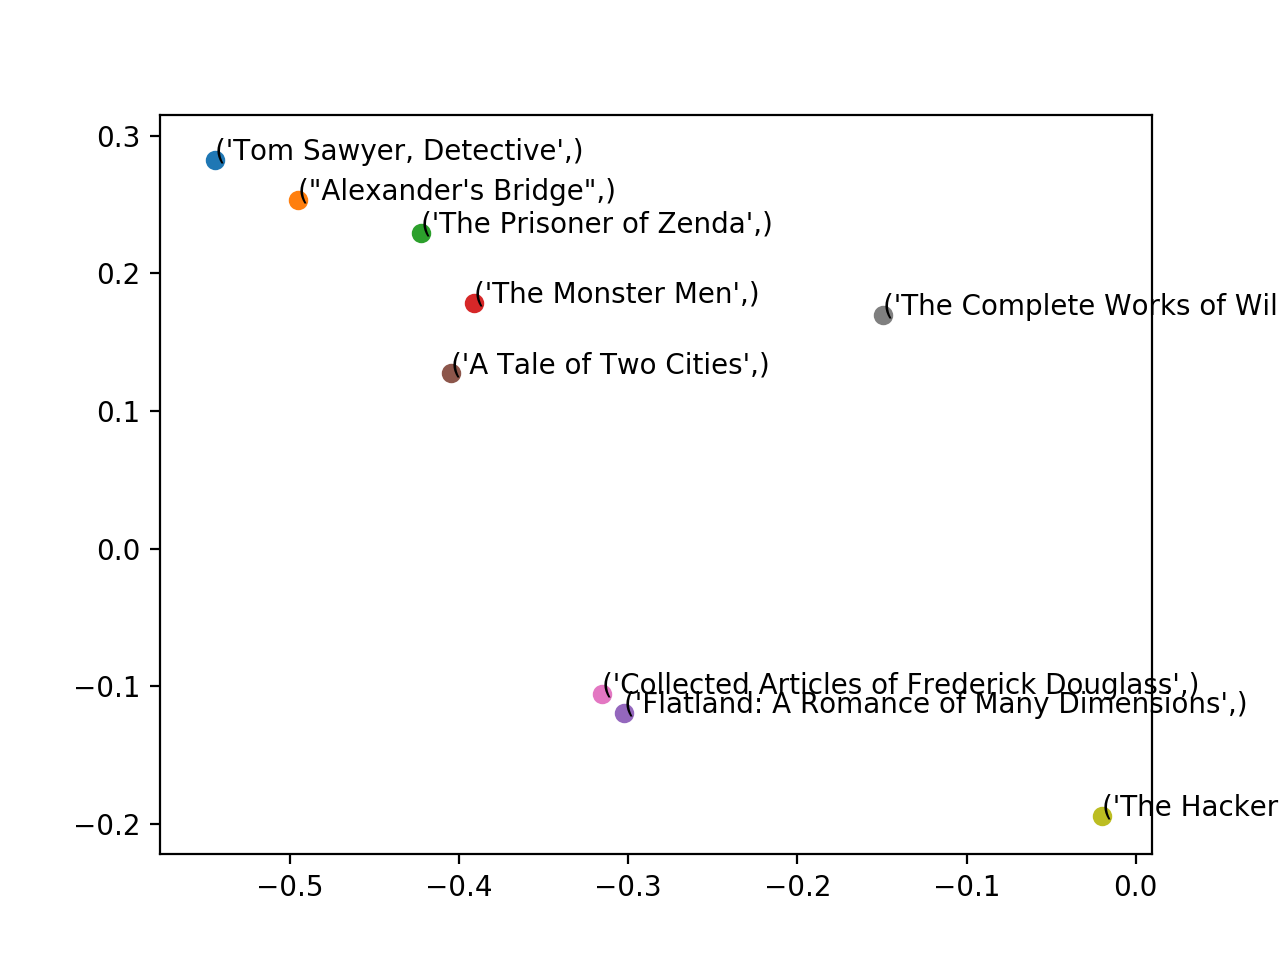

In [21]:
for i in range(90, 99): 
    plt.scatter(xs[i], ys[i])
    plt.annotate(labels[i], (xs[i], ys[i]))

In [80]:
for key, val in possibleDuplicates.items(): 
    for duplicate in val: 
        print("%-25.25s (%s) -similar to- %-25.25s (%s)" % (labels[key][0], key, labels[duplicate[0]][0], duplicate[0]))

The King James Version of (10) -similar to- The Bible, King James Ver (30)
Alice's Adventures in Won (11) -similar to- Through the Looking-Glass (12)
Through the Looking-Glass (12) -similar to- Alice's Adventures in Won (11)
The 1990 CIA World Factbo (14) -similar to- The 1992 CIA World Factbo (48)
Paradise Lost             (20) -similar to- Paradise Lost             (26)
O Pioneers!               (24) -similar to- The Song of the Lark      (44)
O Pioneers!               (24) -similar to- Alexander's Bridge        (91)
Paradise Lost             (26) -similar to- Paradise Lost             (20)
The 1990 United States Ce (29) -similar to- The 1990 United States Ce (37)
The Bible, King James Ver (30) -similar to- The King James Version of (10)
The 1990 United States Ce (37) -similar to- The 1990 United States Ce (29)
The Strange Case of Dr. J (42) -similar to- The Strange Case of Dr. J (43)
The Strange Case of Dr. J (43) -similar to- The Strange Case of Dr. J (42)
The Song of the Lark     